In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import os
from astropy.table import Table

In [2]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)
cosmic_age_array = np.load('/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction/times.npy')

## Redshift-zero results

### Assemble the catalog

In [3]:
from collate_full_catalog import collate_catalog
z_string = 'z0'


history_colnames = ('halo_id', 'halo_upid', 'halo_mpeak', 'sfr_mp', 'sm_mp', 'stellar_mass', 'sfr')

halocat_propnames = ('halo_id', 'first_acc_scale')

cat = collate_catalog(z_string, history_colnames=history_colnames, halocat_propnames=halocat_propnames)

... Assembling history data
... Assembling halo catalog data


### Calculate a few derived quantities

In [4]:
from quenching_time import quenching_time

cat['quenching_time'] = quenching_time(cat['sfr_mp'], cat['sm_mp'])
cat['time_first_acc'] = np.interp(cat['first_acc_scale'], scale_factor_array, cosmic_age_array)

from history_functions import ssfr_at_infall
cat['ssfr_at_infall'] = ssfr_at_infall(cat['sfr_mp'].data, cat['sm_mp'].data, cat['time_first_acc'].data)

In [5]:
from halotools.utils import crossmatch

cat['host_mpeak'] = cat['halo_mpeak']
satmask = cat['halo_upid'] != -1
sats = cat[satmask]
cens = cat[~satmask]

idxA, idxB = crossmatch(sats['halo_upid'], cat['halo_id'])
sats['host_mpeak'][idxA] = cat['halo_mpeak'][idxB]
cat['host_mpeak'][satmask] = sats['host_mpeak']

quenched_satmask = np.log10(sats['sfr']/sats['stellar_mass']) < -11
quenched_sats = sats[quenched_satmask]

### Calculate the quantities of the figure

In [10]:
logsm_low, logsm_high, num_sm_bins = 9, 11.6, 15
sm_bins = np.logspace(logsm_low, logsm_high, num_sm_bins)
sm_mids = 10**((np.log10(sm_bins)[1:] + np.log10(sm_bins)[:-1])/2.)

host_mass_bins = [10**12, 10**13, 10**14, np.inf]

frac_quenched_as_sat = np.zeros(len(sm_bins)-1)
frac_quenched_as_sat_milky_way = np.zeros(len(sm_bins)-1)
frac_quenched_as_sat_group = np.zeros(len(sm_bins)-1)
frac_quenched_as_sat_cluster = np.zeros(len(sm_bins)-1)

for i, sm_low, sm_high in zip(range(len(sm_bins)-1), sm_bins[0:-1], sm_bins[1:]):
    sm_bin_mask = (quenched_sats['stellar_mass'] > sm_low) & (quenched_sats['stellar_mass'] < sm_high)
    sm_bin_active_at_infall_mask = sm_bin_mask * (quenched_sats['ssfr_at_infall'] > -11)
    frac_quenched_as_sat[i] = len(quenched_sats[sm_bin_active_at_infall_mask])/float(len(quenched_sats[sm_bin_mask]))
    
    milky_way_sm_bin_mask = sm_bin_mask*(quenched_sats['host_mpeak'] > host_mass_bins[0])*(quenched_sats['host_mpeak'] < host_mass_bins[1])
    milky_way_sm_bin_active_at_infall_mask = milky_way_sm_bin_mask*(quenched_sats['ssfr_at_infall'] > -11)
    frac_quenched_as_sat_milky_way[i] = len(quenched_sats[milky_way_sm_bin_active_at_infall_mask])/float(len(quenched_sats[milky_way_sm_bin_mask]))

    group_sm_bin_mask = sm_bin_mask*(quenched_sats['host_mpeak'] > host_mass_bins[1])*(quenched_sats['host_mpeak'] < host_mass_bins[2])
    group_sm_bin_active_at_infall_mask = group_sm_bin_mask*(quenched_sats['ssfr_at_infall'] > -11)
    frac_quenched_as_sat_group[i] = len(quenched_sats[group_sm_bin_active_at_infall_mask])/float(len(quenched_sats[group_sm_bin_mask]))

    cluster_sm_bin_mask = sm_bin_mask*(quenched_sats['host_mpeak'] > host_mass_bins[2])*(quenched_sats['host_mpeak'] < host_mass_bins[3])
    cluster_sm_bin_active_at_infall_mask = cluster_sm_bin_mask*(quenched_sats['ssfr_at_infall'] > -11)
    frac_quenched_as_sat_cluster[i] = len(quenched_sats[cluster_sm_bin_active_at_infall_mask])/float(len(quenched_sats[cluster_sm_bin_mask]))

### Plot the results

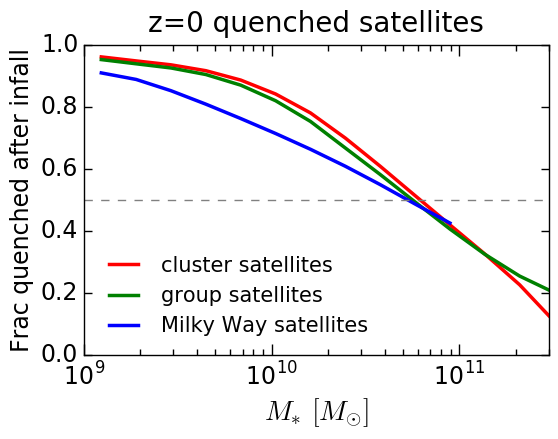

In [11]:
from scipy.signal import savgol_filter

fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=20)
ylabel = ax.set_ylabel('Frac quenched after infall', fontsize=17)
title = ax.set_title('z=0 quenched satellites', fontsize=20, y=1.02) # y param fixes an overhanging title

ax.plot(sm_mids, savgol_filter(frac_quenched_as_sat_cluster, 13, 5), color='red', 
        linewidth=2.5, label = "cluster satellites")

ax.plot(sm_mids, savgol_filter(frac_quenched_as_sat_group, 13, 4), color='green', 
        linewidth=2.5, label = "group satellites")

ax.plot(sm_mids[:-3], savgol_filter(frac_quenched_as_sat_milky_way[:-3], 11, 5), color='blue', 
        linewidth=2.5, label = "Milky Way satellites")

ax.plot(np.logspace(9, 12, 100), np.zeros(100) + 0.5, '--', color='gray')

plt.tick_params(axis='x', length=8, width=1, which='major') 
plt.tick_params(axis='x', length=4, width=1, which='minor') 
plt.tick_params(axis='y', length=6, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim(xmin = 10**9, xmax=3*10**11)
plt.ylim(ymin = 0, ymax = 1)
plt.legend(frameon=False, loc='lower left', fontsize=15)

fig.savefig('FIGS/post_infall_quenching_fractions_z0.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')